## KICKSTARTER PROJECT CLUSTERING

In [1]:
import pandas as pd
import numpy as np

#### CLUSTERING - DATA PREPROCESSING

In [2]:
kickstarter_df = pd.read_excel("Kickstarter.xlsx")

In [3]:
#Fill NA values 
kickstarter_df['main_category']=kickstarter_df['main_category'].fillna("Not Classified")

In [4]:
## Keep rows where state is eigher successful or failed
kickstarter_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]
kickstarter_df['state'].unique()

array(['successful', 'failed'], dtype=object)

In [5]:
#Dropping unrelated variables -- dropping pledged and keep usd_pledged
kickstarter_df = kickstarter_df.drop(columns=['id','name','pledged', 'state_changed_at', 
                         'state_changed_at_weekday',
                         'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr'
                         ])

#### CLUSTERING: FEATURE ENGINEERING 

In [6]:
####### Feature engineering 

kickstarter_df['time_to_launch'] = (kickstarter_df['launched_at'] - kickstarter_df['created_at']).dt.days
kickstarter_df['funding_duration'] = (kickstarter_df['deadline'] - kickstarter_df['launched_at']).dt.days
kickstarter_df = kickstarter_df.drop(columns=['launched_at','created_at','deadline'])

### Calculate category success rate
category_success_rate = kickstarter_df.groupby('category')['state'].apply(lambda x: (x == 'successful').mean())
kickstarter_df['category_success_rate'] = kickstarter_df['category'].map(category_success_rate)

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [8]:
#### Classify category into 3 categories based on their frequency in the dataset  
category_counts = kickstarter_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']  

# Define the frequency_tier function
def frequency_tier(count):
    if count > 250:
        return 'High Frequency'
    elif count > 100:
        return 'Medium Frequency'
    else:
        return 'Low Frequency'

# Apply the frequency_tier function to the 'count' column
category_counts['category_frequency_tier'] = category_counts['count'].apply(frequency_tier)

# Merge frequency tiers back into the original DataFrame
kickstarter_df = kickstarter_df.merge(category_counts[['category', 'category_frequency_tier']], 
                                      on='category', how='left')



In [9]:
# Frequency encoding for category, country, and main_category
frequency_category = kickstarter_df['category'].value_counts().to_dict()
kickstarter_df['category_freq_encoded'] = kickstarter_df['category'].map(frequency_category)

frequency_country = kickstarter_df['country'].value_counts().to_dict()
kickstarter_df['country_freq_encoded'] = kickstarter_df['country'].map(frequency_country)

frequency_main_category = kickstarter_df['main_category'].value_counts().to_dict()
kickstarter_df['main_category_freq_encoded'] = kickstarter_df['main_category'].map(frequency_main_category)

In [10]:
# Dummify 'state'
kickstarter_df['state'] = np.where(kickstarter_df['state'] == 'successful', 1, 0)

In [11]:
# Converting goal to usd for all countries
kickstarter_df['goal_usd'] = kickstarter_df['goal'] * kickstarter_df['static_usd_rate']
kickstarter_df = kickstarter_df.drop(columns=['goal','static_usd_rate'])

In [12]:
kickstarter_df['pledged_goal_difference_usd'] = abs(kickstarter_df['usd_pledged'] - kickstarter_df['goal_usd'])
kickstarter_df['pledged_goal_ratio'] = kickstarter_df['usd_pledged'] / kickstarter_df['goal_usd']

In [13]:
# Log transform for goal, pledged_goal_difference, and usd_pledged, pledged_goal_ratio
kickstarter_df['goal_log'] = np.log1p(kickstarter_df['goal_usd'])
kickstarter_df['pledged_log'] = np.log1p(kickstarter_df['usd_pledged'])
kickstarter_df['goal_pledged_diff_log'] = np.log1p(kickstarter_df['pledged_goal_difference_usd'])
kickstarter_df['pledged_goal_ratio_log'] = np.log1p(kickstarter_df['pledged_goal_ratio'])

In [14]:
features_df = kickstarter_df.copy()
features_df = features_df.drop(columns=['currency','category', 'main_category', 'country',
'created_at_weekday', 'launched_at_weekday', 'deadline_weekday', 
'deadline_month', 'created_at_month', 'deadline_day', 'deadline_yr',
'deadline_hr', 'launched_at_day',
'launched_at_hr', 'created_at_day', 'created_at_yr', 'created_at_hr',
'goal_usd','usd_pledged','pledged_goal_difference_usd', 'pledged_goal_ratio','state'
])

In [15]:
categorical_columns = [
                       'category_frequency_tier'
                       ] 
dummy = pd.get_dummies(features_df[categorical_columns], drop_first=True, dtype=int) 
features_df = pd.concat([features_df, dummy], axis=1)
features_df = features_df.drop(categorical_columns, axis=1)

In [37]:
features_df.head()

,disable_communication,staff_pick,backers_count,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,launched_at_month,launched_at_yr,staff_pick.1,show_feature_image,video,time_to_launch,funding_duration,category_success_rate,category_freq_encoded,country_freq_encoded,main_category_freq_encoded,goal_log,pledged_log,goal_pledged_diff_log,pledged_goal_ratio_log,category_frequency_tier_Low Frequency,category_frequency_tier_Medium Frequency
0,0,0,30,1,4,3,22,20,6,2017,0,0,1,2313,35,0.379310,116,8435,2039,8.612685,8.618124,3.433987,0.695871,0,1
1,0,0,132,1,5,4,25,23,9,2018,0,0,1,2400,30,0.406250,192,8435,1270,9.210440,9.309824,6.952729,0.744078,0,1
2,0,0,152,1,8,6,16,13,4,2019,0,0,1,2590,30,1.000000,267,8435,1606,9.047939,9.264544,7.629004,0.807316,0,0
3,0,0,86,1,5,5,15,14,10,2021,0,0,1,3492,30,1.000000,267,8435,1606,8.517393,8.668540,6.705639,0.771589,0,0
4,0,0,40,0,10,9,19,18,3,2021,0,0,1,3250,31,0.607362,163,8435,1606,9.615872,7.767264,9.444622,0.146176,0,1


#### STANDARDIZE THE VARIABLES

In [16]:
### Transform columns with boolean values to int values for standardization purposes
features_df = features_df.astype({col: 'int' for col in features_df.select_dtypes(include='bool').columns})


In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()
# Apply scaling and create a DataFrame
features_scaled = scaler.fit_transform(features_df)  # Scale the features
features_df_scaled = pd.DataFrame(
    features_scaled,             # Use the scaled NumPy array
    columns=features_df.columns, # Preserve column names
    index=features_df.index      # Preserve index
)



#### REDUCING DIMENSION & FEATURES SELECTION

In [18]:
### perform Isolation Forest to remove anomalies 
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, contamination=0.01, random_state=0)

pred = iforest.fit_predict(features_df_scaled)
score = iforest.decision_function(features_df_scaled)

from numpy import where
anomaly_index = where(pred == -1)[0]  
anomaly_values = features_df_scaled.iloc[anomaly_index]

print("Anomalies Detected:")
print(anomaly_index)

Anomalies Detected:
[   36    71    89    94   107   225   248   294   350   391   439   451
   478   621   777   815  1129  1294  1360  1426  1572  1646  1684  1920
  2389  2398  2473  2489  2515  2680  2801  2884  2888  3295  3337  3443
  3798  3872  3911  3970  4021  5188  5264  5292  5324  5768  5982  6056
  6167  6239  6324  6801  6977  7076  7357  7449  7595  7599  7762  7805
  7919  8155  8225  8291  8327  8420  8524  8527  8544  8571  8633  8812
  8920  8992  9103  9140  9167  9334  9389  9406  9416  9512  9557  9575
  9634  9635  9820  9923 10119 10885 10889 11028 11083 11204 11257 11377
 11454 11787 11822 11844 11863 11930 11940 12017 12042 12091 12264 12388
 12601 12623 12661 12724 12733 12807 12823 12930 12975 12996 13046 13059
 13061 13213 13286 13347 13359 13376 13406 13463 13469 13632 13641 13722
 13769 13884 13885 13944 14008 14062 14086 14114 14166 14253 14256 14274
 14319]


In [19]:
features_df_cleaned = features_df_scaled.drop(index=anomaly_index)
features_scaled_cleaned = features_scaled[features_df_cleaned.index]


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler


vif_data = pd.DataFrame()
vif_data["Feature"] = features_df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(features_df_cleaned, i) for i in range(features_df_cleaned.shape[1])]

print(vif_data)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                                     Feature        VIF
0                      disable_communication        NaN
1                                 staff_pick   1.194247
2                              backers_count   1.473195
3                                  spotlight   5.478333
4                                   name_len  19.789174
5                             name_len_clean  19.876663
6                                  blurb_len  31.478901
7                            blurb_len_clean  31.575835
8                          launched_at_month   1.006423
9                             launched_at_yr   1.177964
10                              staff_pick.1        NaN
11                        show_feature_image   1.028568
12                                     video   1.192155
13                            time_to_launch   1.035393
14                          funding_duration   1.119745
15                     category_success_rate   1.733213
16                     category_freq_encoded   6

In [21]:
### Remove highly correlated features 
features_df_cleaned = features_df_cleaned.drop(columns=['name_len', 'blurb_len'])

In [32]:
features_df_cleaned.describe()

,disable_communication,staff_pick,backers_count,spotlight,name_len_clean,blurb_len_clean,launched_at_month,launched_at_yr,staff_pick.1,show_feature_image,video,time_to_launch,funding_duration,category_success_rate,category_freq_encoded,country_freq_encoded,main_category_freq_encoded,goal_log,pledged_log,goal_pledged_diff_log,pledged_goal_ratio_log,category_frequency_tier_Low Frequency,category_frequency_tier_Medium Frequency,cluster,state
count,14318.0,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.0,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000
mean,0.0,-0.013221,-0.045268,-0.007957,-0.003319,0.000582,0.000543,-0.004400,0.0,-0.027693,-0.004279,-0.007573,-0.001078,-0.006581,0.003155,0.002202,0.003811,-0.005177,-0.015429,-0.014880,-0.025083,-0.004251,0.003083,2.388392,0.573474
std,0.0,0.986370,0.433068,1.001249,0.997365,0.999402,0.998949,0.996937,0.0,0.924818,1.001334,0.981785,0.999574,0.998665,0.998400,0.999363,0.999912,0.995527,0.989347,0.987607,0.952569,0.997878,1.000264,1.794638,0.494589
min,0.0,-0.408462,-0.218735,-1.168901,-1.756177,-2.561264,-1.547925,-1.332920,0.0,-0.185675,-1.351671,-0.318521,-2.517977,-1.966170,-1.702468,-1.372006,-2.341947,-4.492023,-2.305251,-3.074754,-0.910350,-0.615420,-0.926950,0.000000,0.000000
25%,0.0,-0.408462,-0.209063,-1.168901,-0.879043,-0.728613,-0.960747,-0.803421,0.0,-0.185675,-1.351671,-0.303890,-0.359341,-0.742431,-0.855823,-1.187426,-0.971061,-0.681198,-0.572959,-0.617527,-0.860802,-0.615420,-0.926950,1.000000,0.000000
50%,0.0,-0.408462,-0.168441,0.855505,-0.001910,0.187713,-0.079979,-0.273921,0.0,-0.185675,0.739825,-0.255123,-0.282247,-0.195473,-0.150285,0.839279,0.278011,0.095641,0.215369,0.039877,0.047266,-0.615420,-0.926950,2.000000,1.000000
75%,0.0,-0.408462,-0.052379,0.855505,0.875223,0.737508,0.800788,0.785079,0.0,-0.185675,0.739825,-0.108819,0.257412,0.900647,0.668139,0.839279,0.759465,0.625636,0.710412,0.676988,0.243364,1.624907,1.078807,4.000000,1.000000
max,0.0,2.448206,12.546154,0.855505,3.945189,2.386894,1.681556,2.373578,0.0,5.385743,0.739825,18.696036,6.656225,1.439017,2.502537,0.839279,1.403336,5.905947,2.284358,4.542265,11.497248,1.624907,1.078807,5.000000,1.000000


#### BUILD THE MODEL

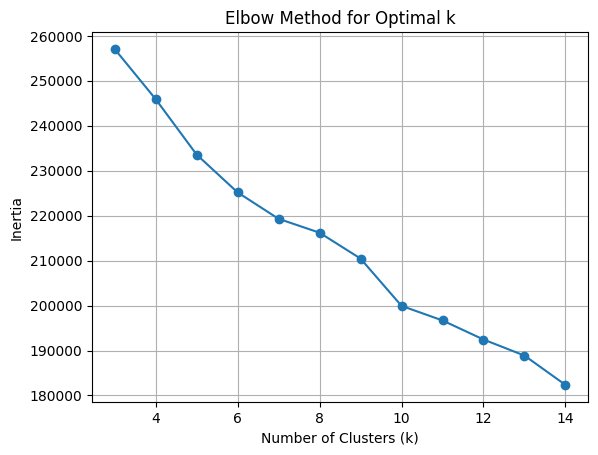

In [45]:
### KMEANS 

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
inertia = []
k_values = range(3, 15)  # Test k from 1 to 15

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_scaled_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [42]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(3,15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    model = kmeans.fit(features_scaled_cleaned)
    labels = model.labels_
    score = silhouette_score(features_scaled_cleaned, labels)
    silhouette_scores.append(score)
    print(i,':',silhouette_score(features_scaled_cleaned, labels))


3 : 0.10545707350711263
4 : 0.10632919266509964
5 : 0.10546626190586113
6 : 0.10677967701593918
7 : 0.10092981096787552
8 : 0.10023532412857981
9 : 0.08899995312880991
10 : 0.0991400547254587
11 : 0.094942169454744
12 : 0.09340137861562706
13 : 0.09347855125564374
14 : 0.09578597737534686


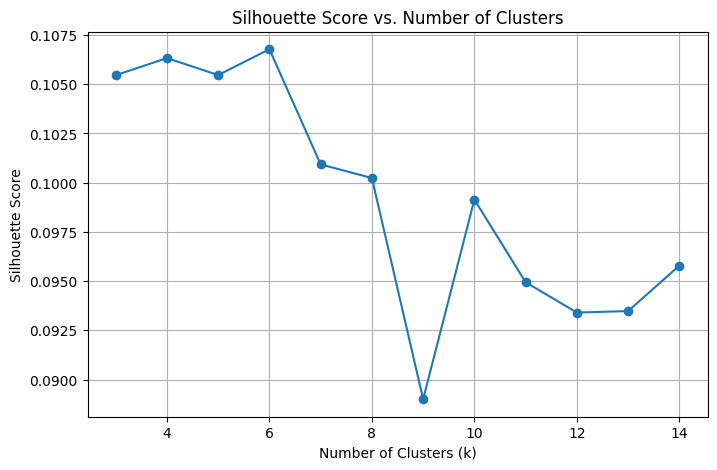

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import calinski_harabasz_score

for i in range(3,15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    model = kmeans.fit(features_scaled_cleaned)
    labels = model.labels_
    print(i, calinski_harabasz_score(features_scaled_cleaned,labels))

3 1534.085896349456
4 1285.1372741076934
5 1203.8580666155785
6 1105.966196282748
7 1010.285690235594
8 907.4939073636782
9 864.6148464807334
10 892.6008375756805
11 840.1506914222356
12 809.2001959479408
13 778.3381047194846
14 783.4754686213388


##### Decided to use Silhouette score to determine the optimal number of clusters. Based on the result, the optimal k is 6 

#### USING THE MODEL FOR CLUSTERING

In [25]:
# Fit K-Means with the optimal k 
optimal_k = 6  # Based on Silhouette analysis
kmeans_final = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_final.fit(features_scaled_cleaned)

features_df_cleaned['cluster'] = kmeans_final.labels_

print(features_df_cleaned.groupby('cluster').mean())

         disable_communication  staff_pick  backers_count  spotlight  \
cluster                                                                
0                          0.0   -0.359018      -0.055356   0.675051   
1                          0.0   -0.392210      -0.199258  -1.168901   
2                          0.0    0.003119      -0.008022   0.840518   
3                          0.0    2.446429       0.336932   0.747167   
4                          0.0   -0.320704      -0.192768  -1.168901   
5                          0.0   -0.406485       0.030079   0.822571   

         name_len_clean  blurb_len_clean  launched_at_month  launched_at_yr  \
cluster                                                                       
0             -0.439908        -1.090306          -0.005788        0.475536   
1             -0.112941         0.144302           0.028968       -0.194092   
2              0.093246         0.051934          -0.007920       -0.048974   
3              0.198133     

In [27]:
### Added 'state' variable to inspect the success rate
features_df_cleaned['state'] = kickstarter_df['state'].loc[features_df_cleaned.index]
cluster_state_distribution = pd.crosstab(features_df_cleaned['cluster'], features_df_cleaned['state'])
print(cluster_state_distribution)

state       0     1
cluster            
0         206  2105
1        3867     0
2          13  1743
3          86  1521
4        1888     0
5          47  2842


In [28]:
# Calculate success rates
cluster_state_distribution['success_rate'] = (
    cluster_state_distribution[1] /
    (cluster_state_distribution[0] + cluster_state_distribution[1])
)

print(cluster_state_distribution[['success_rate']])

state    success_rate
cluster              
0            0.910861
1            0.000000
2            0.992597
3            0.946484
4            0.000000
5            0.983731
